# Driver Standing and Constructor Standings Predictions

This projects aims to predict future standings based on past performance trends

In [25]:
import pandas as pd

# Load the datasets
driver_standings = pd.read_csv('f1/driver_standings.csv')
constructor_standings = pd.read_csv('f1/constructor_standings.csv')
races = pd.read_csv('f1/races.csv')
drivers = pd.read_csv('f1/drivers.csv')
constructors = pd.read_csv('f1/constructors.csv')
results = pd.read_csv('f1/results.csv')

# Cleaning the datasets
driver_standings.drop(['positionText'], axis=1, inplace=True)
constructor_standings.drop(['positionText'], axis=1, inplace=True)
races.drop(['url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time'], axis=1, inplace=True)
drivers.drop(['driverRef', 'number', 'forename', 'dob', 'nationality', 'url'], axis=1, inplace=True)
constructors.drop(['url', 'name', 'nationality'], axis=1, inplace=True)

# Merge the datasets
merged = pd.merge(results, races, on='raceId', how='outer')
merged = pd.merge(merged, driver_standings, on=['raceId', 'driverId'], how='left')
merged = pd.merge(merged, constructor_standings, on=['raceId', 'constructorId'], how='left')
merged = pd.merge(merged, drivers, on='driverId', how='left')
merged = pd.merge(merged, constructors, on='constructorId', how='left')

# Filter to specific years (2018 - 2022)
merged = merged[(merged['year'] >= 2018) & (merged['year'] <= 2022)]

# Sort the merged dataset by date and round
merged.sort_values(by=['year', 'round'], ascending=[True, True], inplace=True)

# Renaming columns for clarity
merged.rename(columns={
    'position': 'race_finish_position',  
    'positionOrder': 'race_position_order',  
    'points_x': 'driver_season_points',  
    'points_y': 'constructor_season_points',  
    'wins_x': 'driver_season_wins',  
    'wins_y': 'constructor_season_wins',  
    'position_x': 'driver_championship_standings',  
    'position_y': 'constructor_championship_standings'
}, inplace=True)

# Handling missing values
# For numerical columns: filling with the mean or median
numerical_cols = merged.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    merged[col].fillna(merged[col].mean(), inplace=True)

# For categorical columns: filling with the mode
categorical_cols = merged.select_dtypes(include=['object']).columns
for col in categorical_cols:
    merged[col].fillna(merged[col].mode()[0], inplace=True)

# Save the cleaned and preprocessed merged dataset
merged.to_csv('f1/merged_dataset.csv', index=False)


In [26]:
# One-hot encoding for nominal categorical variables
merged = pd.get_dummies(merged, columns=['circuitId', 'constructorId'])

In [32]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1_l2

# Load the merged dataset
file_path = 'f1/merged_dataset.csv'  # Update with the correct path
data = pd.read_csv(file_path)

# Convert target columns to numeric (float) and handle any missing or non-numeric values
data['driver_championship_standings'] = pd.to_numeric(data['driver_championship_standings'], errors='coerce').fillna(0)
data['constructor_championship_standings'] = pd.to_numeric(data['constructor_championship_standings'], errors='coerce').fillna(0)

# Selecting features and target
feature_columns = ['grid', 'driver_season_points', 'driver_season_wins', 'constructor_season_points', 'constructor_season_wins', 'laps', 'race_position_order']
X = data[feature_columns]
y_driver = data['driver_championship_standings']  # Target for driver standings
y_constructor = data['constructor_championship_standings']  # Target for constructor standings

# Splitting the dataset into training and testing sets
X_train, X_test, y_train_driver, y_test_driver = train_test_split(X, y_driver, test_size=0.2, random_state=42)
_, _, y_train_constructor, y_test_constructor = train_test_split(X, y_constructor, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a function to create the Keras model
def create_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        Dropout(0.5),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Correct the input shape for model creation
input_shape = (X_train_scaled.shape[1], )  # Number of features

# Create and train the model for driver standings
model_driver = create_model(input_shape)
history_driver = model_driver.fit(X_train_scaled, y_train_driver, epochs=100, batch_size=10, validation_split=0.2)

# Evaluate the model for driver standings
y_pred_driver = model_driver.predict(X_test_scaled)
mse_driver = tf.keras.losses.MeanSquaredError()
print("Driver Standings - Mean Squared Error:", mse_driver(y_test_driver, y_pred_driver).numpy())

# Create and train the model for constructor standings
model_constructor = create_model(input_shape)
history_constructor = model_constructor.fit(X_train_scaled, y_train_constructor, epochs=100, batch_size=10, validation_split=0.2)

# Evaluate the model for constructor standings
y_pred_constructor = model_constructor.predict(X_test_scaled)
print("Constructor Standings - Mean Squared Error:", mse_driver(y_test_constructor, y_pred_constructor).numpy())


Epoch 1/100


/Users/ali/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step - loss: 78.0938 - val_loss: 26.6759
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 37.1404 - val_loss: 24.3835
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 31.7517 - val_loss: 20.7250
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 28.4852 - val_loss: 19.1868
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 26.5930 - val_loss: 19.0439
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 28.1946 - val_loss: 18.3336
Epoch 7/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 23.0765 - val_loss: 17.2191
Epoch 8/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 23.5651 - val_loss: 17.8767
Epoch 9/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 21.6544 - val_loss: 15.6798
Epoch 10/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 23.9098 - val_loss: 14.7806
Epoch 11/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 22.8009 - val_loss: 15.7910
Epoch 12/

/Users/ali/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - loss: 106.3226 - val_loss: 20.9587
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 34.4424 - val_loss: 16.9817
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 32.2902 - val_loss: 17.7281
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 27.6683 - val_loss: 15.2812
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 28.1872 - val_loss: 14.5247
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 26.2283 - val_loss: 14.3518
Epoch 7/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 25.7011 - val_loss: 12.3809
Epoch 8/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 23.7823 - val_loss: 12.8320
Epoch 9/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 22.3697 - val_loss: 11.9212
Epoch 10/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 21.8957 - val_loss: 11.1801
Epoch 11/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 22.4923 - val_loss: 11.4282
Epoch 12

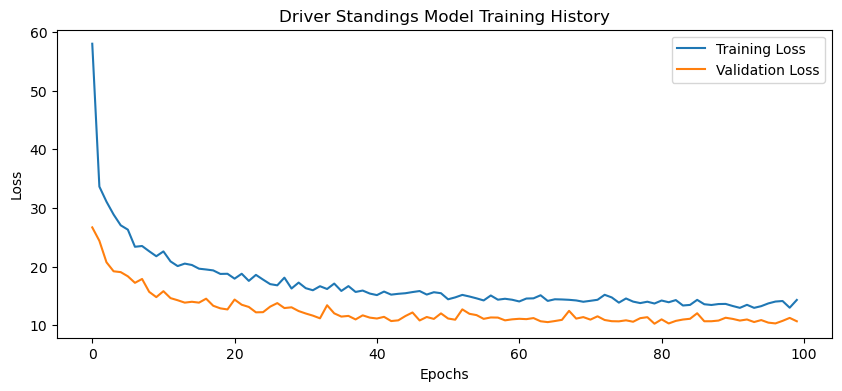

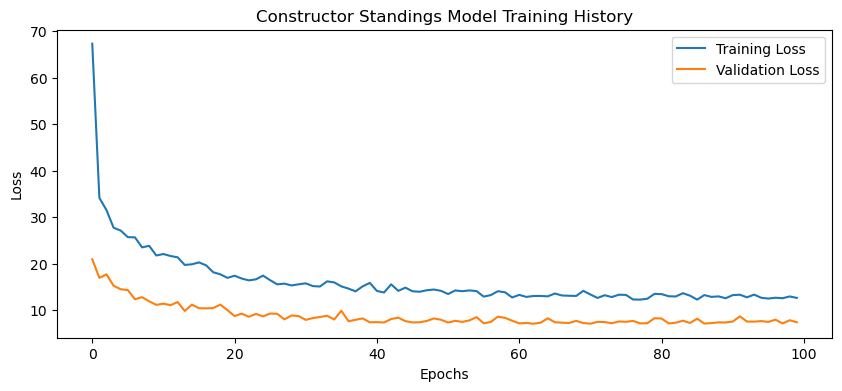

In [33]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history, title):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot the training history for driver standings model
plot_training_history(history_driver, 'Driver Standings Model Training History')

# Plot the training history for constructor standings model
plot_training_history(history_constructor, 'Constructor Standings Model Training History')


In [48]:
# Aggregating driver data
driver_stats = data[data['driverId'] == 825.0][feature_columns].mean()  

# Converting to DataFrame for scaling
driver_stats_df = pd.DataFrame([driver_stats])

# Scaling features
driver_stats_scaled = scaler.transform(driver_stats_df)

# Predict driver standings
predicted_driver_standing = model_driver.predict(driver_stats_scaled)
print(f"Predicted Driver Standing for Driver ID 1.0:", predicted_driver_standing[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted Driver Standing for Driver ID 1.0: 12.93042


In [45]:
# Aggregating constructor data
constructor_stats = data[data['constructorId'] == 131.0][feature_columns].mean()  

# Converting to DataFrame for scaling
constructor_stats_df = pd.DataFrame([constructor_stats])

# Scaling features
constructor_stats_scaled = scaler.transform(constructor_stats_df)

# Predict constructor standings
predicted_constructor_standing = model_constructor.predict(constructor_stats_scaled)
print(f"Predicted Constructor Standing for Constructor ID 131.0:", predicted_constructor_standing[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicted Constructor Standing for Constructor ID 131.0: 3.5026972
